In [2]:
%pip install torchview

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch tools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models, Module
from torchsummary import summary
from torchview import draw_graph

# Sklearn tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# opencv tools
import cv2

# Load Dataset

In [4]:
# The train & test sets
g_train = {"fake": [], "real": []}
g_test  = {"fake": [], "real": []}

# Base directories
base_dirs = [
    "../input/deepfake-image-detection/train-20250112T065955Z-001",
    "../input/deepfake-image-detection/test-20250112T065939Z-001"
]

# Labels
labels = ["fake", "real"]

# Reading the images
for base_dir in base_dirs:
    for label in labels:
        # Constructing the image directory path
        img_dir = os.path.join(base_dir, "train" if "train" in base_dir else "test", label)
        
        # Listing all files in the directory and construct full paths
        files = [os.path.join(img_dir, x) for x in os.listdir(img_dir)]
        
        # Appending files to the appropriate dictionary
        if "train" in base_dir:
            g_train[label] += files
        else:
            g_test[label] += files
print("Done!")

Done!


In [5]:
# Merging all images and labels accordingly
all_images = []
all_labels = []
for label in labels:
    all_images += g_train[label] + g_test[label]
    all_labels += [label]*len(g_train[label]) + [label]*len(g_test[label])

print("Done!")

Done!


In [6]:
# display the tabels
data = pd.DataFrame({"images": all_images, "labels":all_labels})
display(data)

,images,labels
0,../input/deepfake-image-detection/train-202501...,fake
1,../input/deepfake-image-detection/train-202501...,fake
2,../input/deepfake-image-detection/train-202501...,fake
3,../input/deepfake-image-detection/train-202501...,fake
4,../input/deepfake-image-detection/train-202501...,fake
...,...,...
973,../input/deepfake-image-detection/test-2025011...,real
974,../input/deepfake-image-detection/test-2025011...,real
975,../input/deepfake-image-detection/test-2025011...,real
976,../input/deepfake-image-detection/test-2025011...,real


In [7]:
# for Randomization, shuffle the data
data = data.sample(frac=1, random_state=42)  # Shuffle in place
data.reset_index(drop=True, inplace=True)  # Reset index in place

# Display the shuffled DataFrame
display(data)

,images,labels
0,../input/deepfake-image-detection/test-2025011...,fake
1,../input/deepfake-image-detection/train-202501...,real
2,../input/deepfake-image-detection/test-2025011...,fake
3,../input/deepfake-image-detection/test-2025011...,real
4,../input/deepfake-image-detection/train-202501...,fake
...,...,...
973,../input/deepfake-image-detection/train-202501...,fake
974,../input/deepfake-image-detection/test-2025011...,fake
975,../input/deepfake-image-detection/train-202501...,real
976,../input/deepfake-image-detection/test-2025011...,fake


In [8]:
# Converting the labels into numeric format
label_map = {'fake': 0, 'real':1}
# apply into the table
data['labels'] = data['labels'].map(label_map)
display(data)

,images,labels
0,../input/deepfake-image-detection/test-2025011...,0
1,../input/deepfake-image-detection/train-202501...,1
2,../input/deepfake-image-detection/test-2025011...,0
3,../input/deepfake-image-detection/test-2025011...,1
4,../input/deepfake-image-detection/train-202501...,0
...,...,...
973,../input/deepfake-image-detection/train-202501...,0
974,../input/deepfake-image-detection/test-2025011...,0
975,../input/deepfake-image-detection/train-202501...,1
976,../input/deepfake-image-detection/test-2025011...,0


# Read the images

In [9]:
Images = []
Labels = []
# height and weidth
max_height = float('-inf')
min_height = float('inf')
max_weidth = float('-inf')
min_weidth = float('inf')
for i in range(len(data)):
    image_path = data['images'][i]
    label = data['labels'][i]
    try:
        # read images 
        img = cv2.imread(image_path)
        # convert BGR  to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is None:
           raise FileNotFoundError("Image not found or unable to read the file.")
        Images.append(img)
        Labels.append(label)
        max_height = max(max_height, img.shape[0])
        min_height = min(min_height, img.shape[0])
        max_weidth = max(max_weidth, img.shape[1])
        min_weidth  = min(min_weidth, img.shape[1])
    except Exception as e:
        print("An unexpected error occurred:", e)

print(f"Max Height: {max_height}")
print(f"Min Height: {min_height}")

print(f"Max Weidth: {max_weidth}")
print(f"Min Weidth: {min_weidth}")

libpng warning: iCCP: profile 'ICC Profile': 'CMYK': invalid ICC profile color space


Max Height: 7091
Min Height: 135
Max Weidth: 8495
Min Weidth: 183


In [ ]:
# Visualize some images
# number of images
num_imgs = 20
ncols = 4
nrows = (num_imgs + ncols - 1) // ncols
# Create a figure to display the images
plt.figure(figsize=(15, 10))
for i, img in enumerate(Images[:num_imgs]):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(img)
    plt.title(f"Label: {Labels[i]}")
    plt.axis('off')
plt.show()

In [ ]:
# resize the images
target_size = (224,224)
Images_resize = [cv2.resize(img, target_size) for img in Images]

# Visualize some images
# number of images
num_imgs = 20
ncols = 4
nrows = (num_imgs + ncols - 1) // ncols
# Create a figure to display the images
plt.figure(figsize=(15, 10))
for i, img in enumerate(Images_resize[:num_imgs]):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(img)
    plt.title(f"Label: {Labels[i]}")
    plt.axis('off')
plt.show()

# Train, Validation, and Test Spliting

In [12]:
# Step 1: Spliting into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(Images_resize, Labels, test_size=0.2, random_state=42)

# Step 2: Split the training set into 80% training and 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Step 5: Verify the shapes of the generators
print("Training data shape:", len(X_train))
print("Validation data shape:", len(X_val))
print("Testing data shape:", len(X_test))

Training data shape: 625
Validation data shape: 157
Testing data shape: 196


# Count of fake and real images in training set

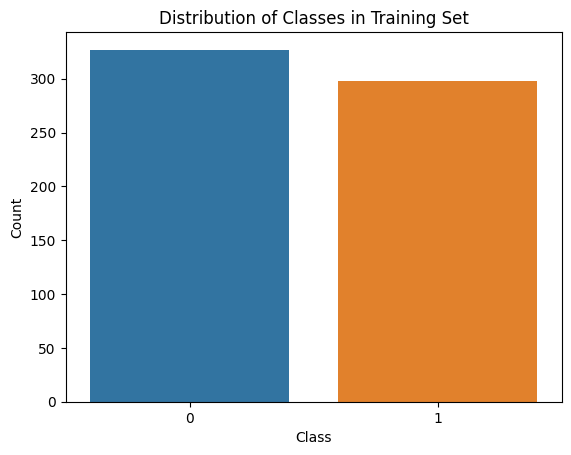

In [13]:
# Create a count plot
sns.countplot(x=np.array(y_train))

# Add labels and title
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Distribution of Classes in Training Set")

# Show the plot
plt.show()

# Custome Dataset

In [14]:
# Define Transformations: Augment First, Then Normalize
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert OpenCV (NumPy) image to PIL format
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # Convert to Tensor [0,1], normalized pixel
])

class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        images: List of NumPy arrays (H, W, C) 
        labels: List or NumPy array of shape (N,)
        transform: Augmentation transformations
        """
        self.images = np.array(images)  # Keep as NumPy array, apply transforms later
        self.labels = torch.tensor(np.array(labels), dtype=torch.long)
        self.transform = transform  # Store the transform function

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        if self.transform:
            image = self.transform(image)  # Apply augmentations

        label = self.labels[idx]
        return image, label

# Create dataset and DataLoader
train_dataset = CustomImageDataset(X_train, y_train, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = CustomImageDataset(X_val, y_val, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [15]:
# Fetch one batch
images, labels = next(iter(train_dataloader))
print(images.shape)  # Expected: [batch_size, 3, H, W]
print(labels)

torch.Size([64, 3, 224, 224])
tensor([1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
        0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0])


# Train Model

In [16]:
# Load the pretrained model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Freeze all layers except the last ones
for param in model.parameters():
    param.requires_grad = False  # Unfreeze all layers

# Modify the fully connected (FC) layer
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),  # First fully connected layer
    nn.BatchNorm1d(1024),       # Batch Normalization
    nn.LeakyReLU(),             # Activation function
    nn.Dropout(0.5),            # Dropout for regularization
    
    nn.Linear(1024, 512),       # Second fully connected layer
    nn.BatchNorm1d(512),        # Batch Normalization
    nn.LeakyReLU(),             # Activation function
    nn.Dropout(0.5),            # Dropout for regularization
    
    nn.Linear(512, 1),          # Final fully connected layer
    nn.Sigmoid()                # Sigmoid activation for binary classification
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s]


In [17]:
# Define Loss Function & Optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define Accuracy Function
def binary_accuracy(preds, labels):
    preds = (preds >= 0.5).float()  # Convert probabilities to binary (0 or 1)
    return (preds == labels).sum().item() / labels.size(0)

# Adaptive Learning Rate Scheduler (Reduce LR if val_loss does not improve for 3 epochs)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# Training Function
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10, save_path="best_model.pth"):
    best_val_loss = float('inf') 
    for epoch in range(epochs):
        model.train()
        train_loss, train_acc = 0.0, 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)  # Ensure labels are float

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += binary_accuracy(outputs, labels)

        # Validation
        model.eval()
        val_loss, val_acc = 0.0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_acc += binary_accuracy(outputs, labels)
        # Reduce LR if validation loss does not improve
        scheduler.step(val_loss)

        # Save Best Model (Based on Validation Loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print(f"Saving the Model with loss{best_val_loss}")
            torch.save(model.state_dict(), save_path)
        # Get the current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        # Print Training and Validation Metrics
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc/len(train_loader):.4f} | "
              f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc/len(val_loader):.4f}|",
              f"LR:{current_lr:.6f} ")

In [18]:
# training 
train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epochs=100, save_path="best_resnet50.pth")

Saving the Model with loss2.0284650921821594
Epoch 1/100 | Train Loss: 0.7047, Train Acc: 0.5356 | Val Loss: 0.6762, Val Acc: 0.7633| LR:0.000100 
Saving the Model with loss1.910669982433319
Epoch 2/100 | Train Loss: 0.5987, Train Acc: 0.7000 | Val Loss: 0.6369, Val Acc: 0.6861| LR:0.000100 
Saving the Model with loss1.7596752643585205
Epoch 3/100 | Train Loss: 0.5245, Train Acc: 0.7574 | Val Loss: 0.5866, Val Acc: 0.7455| LR:0.000100 
Saving the Model with loss1.6008399724960327
Epoch 4/100 | Train Loss: 0.4648, Train Acc: 0.8007 | Val Loss: 0.5336, Val Acc: 0.7696| LR:0.000100 
Epoch 5/100 | Train Loss: 0.4359, Train Acc: 0.8113 | Val Loss: 0.5389, Val Acc: 0.7101| LR:0.000100 
Saving the Model with loss1.3889712989330292
Epoch 6/100 | Train Loss: 0.3875, Train Acc: 0.8509 | Val Loss: 0.4630, Val Acc: 0.8019| LR:0.000100 
Epoch 7/100 | Train Loss: 0.3508, Train Acc: 0.8660 | Val Loss: 0.4751, Val Acc: 0.7759| LR:0.000100 
Epoch 8/100 | Train Loss: 0.3223, Train Acc: 0.8920 | Val Loss

# Performance on Test Data

In [19]:
test_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert OpenCV (NumPy) image to PIL format
    transforms.ToTensor(),  # Convert to Tensor [0,1], normalized pixel
])
test_dataset = CustomImageDataset(X_test, y_test, transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=len(X_test), shuffle=False)
# Validation
model.eval()
val_acc = 0.0
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

        outputs = model(images)
        val_acc += binary_accuracy(outputs, labels)
print(f"Test Accuracy: {val_acc}")

Test Accuracy: 0.826530612244898


# Final train & test accuracy are: 99.06% & 81.63%

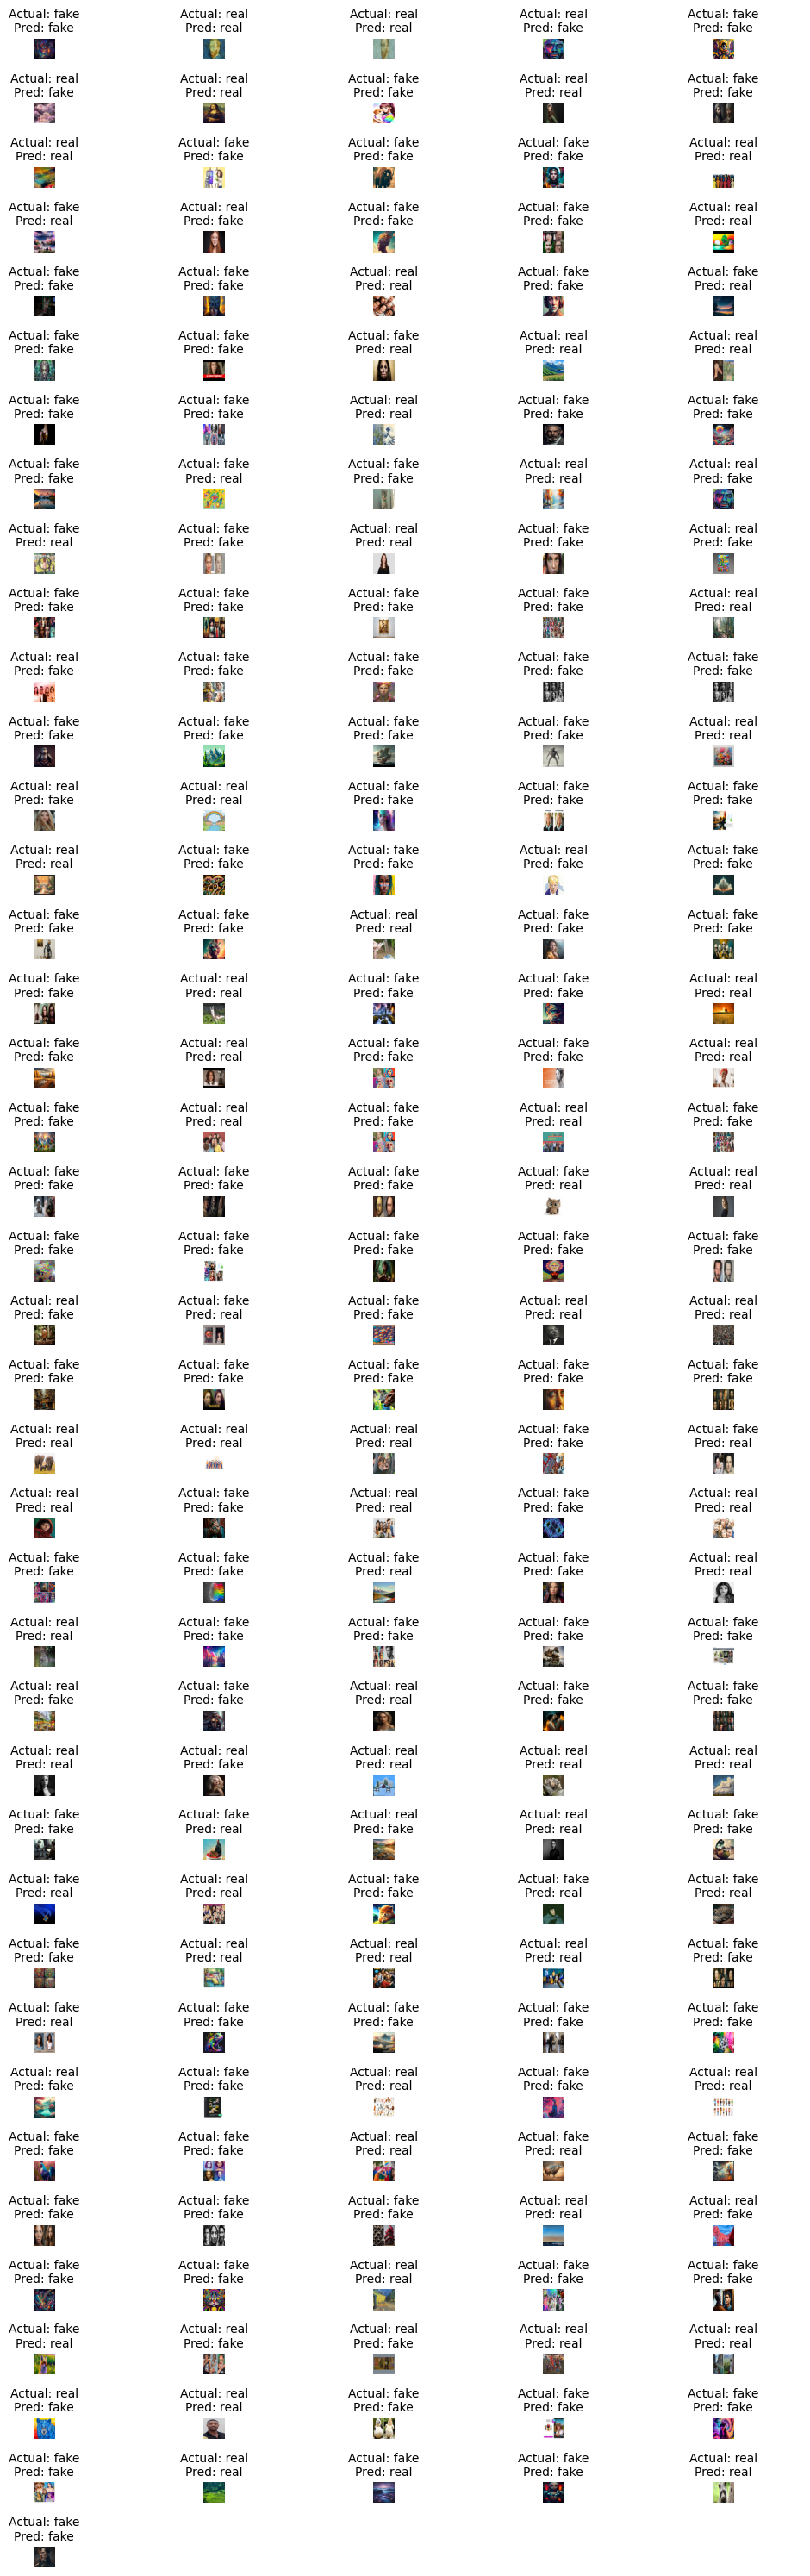

In [21]:
def plot_test_images(image_list, labels, preds, class_names, num_images=10):
    """
    image_list: List of test images (NumPy arrays in [H, W, C] format).
    labels: List or array of actual labels.
    preds: List or array of predicted labels.
    class_names: Dictionary or list mapping label indices to class names.
    num_images: Number of images to display.
    """
    num_images = min(num_images, len(image_list))  # Ensure we don't exceed available images
    ncols = 5
    nrows = int(np.ceil(num_images / ncols))  # Round up rows to fit all images

    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 30))
    axes = axes.flatten()
    
    for i in range(num_images):
        img = image_list[i]  # Get image
        actual_label = class_names[labels[i]]
        predicted_label = class_names[1 if preds[i] >= 0.5 else 0]
        axes[i].imshow(img)
        axes[i].set_title(f"Actual: {actual_label}\nPred: {predicted_label}", fontsize=10)
        axes[i].axis("off")
    # Hide unused subplots (if any)
    for i in range(num_images, len(axes)):  
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()
# Plot
plot_test_images(image_list=X_test,labels=y_test, preds=outputs, class_names={0: "fake", 1: "real"}, num_images=len(X_test))